### libray inclusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,roc_curve,recall_score,roc_auc_score,auc,confusion_matrix,cohen_kappa_score, f1_score, precision_score,matthews_corrcoef 
from tqdm import tqdm
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, SelectFromModel, SelectKBest
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Optional imports for preprocessing and visualization
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Set the display options to show all columns
pd.set_option('display.max_columns', None)

Radiomics Feature Analysis

In [3]:
Final_accuracy={}

In [4]:
import pandas as pd

# Load the main dataset
main_df = pd.read_csv("./Radiomics_Feature.csv")

# Load the test dataset
test_df = pd.read_csv("./Radiomics_Features_Train.csv")

# Identify rows in the main dataset that are also present in the test dataset
test_indices = main_df.merge(test_df, on=['Patient_id'], how='inner').index

# Remove the test data details from the main dataset
cleaned_main_df = main_df.drop(test_indices)

# Save the cleaned main dataset to a new CSV file
cleaned_main_df.to_csv("Radiomics_Feature_Train.csv", index=False)


In [5]:

df_rm = pd.read_csv("./Radiomics_Features_Train.csv")



df_rm .head()
print(df_rm.shape)


(1114, 1221)


In [6]:
df_rm['Malignancy'].value_counts()

0    828
1    286
Name: Malignancy, dtype: int64

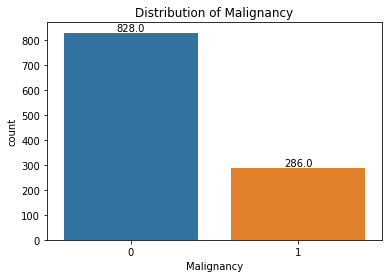

In [7]:
# If you want to order the bars by count, you can use the order parameter
order = df_rm['Malignancy'].value_counts().index
ax = sns.countplot(x='Malignancy', data=df_rm, order=order)

plt.title('Distribution of Malignancy')

# Annotate each bar with its count value
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

Radiomics Model Analysis with 1218 Features

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import joblib

# Load your dataset
df = pd.read_csv("./Radiomics_Features_Train.csv")

# Define features and target
X = df.drop(columns=['Patient_id', 'nodule no','Malignancy'])
y = df['Malignancy']

# Use RandomOverSampler to oversample the minority class
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Standardize the data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Convert the resampled features and target back to DataFrame for ease of handling
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.Series(y_resampled, name='Malignancy')

# Combine the resampled features and target back into a DataFrame
df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Prepare data for cross-validation
X = df_resampled.drop(columns='Malignancy')
y = df_resampled['Malignancy']

# Define the number of folds (K)
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
accuracy_scores = []
best_accuracy = 0
best_model = None

# Specify hyperparameters
rf_hyperparameters = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

# Split the dataset into K folds
for fold, (train_indices, test_indices) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}:")

    # Split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    # Train the model
    model = RandomForestClassifier(random_state=42, **rf_hyperparameters)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    #y_test = np.array(y_test).reshape(-1)
    #y_pred = np.array(y_pred).reshape(-1)
    #print(y_pred.shape,y_pred)
    # Ensure y_test and y_pred are 1-dimensional
    #y_test = y_test.ravel()
   # y_pred = y_pred.ravel()
    
    #print(y_test.shape,y_test)
    #y_test = y_test.values[:, -1]
    #y_pred = y_pred[:, -1]
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Check if current model is the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

    print("-" * 30)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save the best model
joblib.dump(best_model, 'best_random_forest_model_1218_features.pkl')

# Standardize the full dataset for making final predictions
X_standardized = scaler.transform(X)
y_pred_best = best_model.predict(X_standardized)

# Save predictions to a CSV file
df_predictions = pd.DataFrame({'True Label': y, 'Predicted Label': y_pred_best})
df_predictions.to_csv('predictions_1218.csv', index=False)
Final_accuracy['Accuracy with 1218 Features']=best_accuracy
# Calculate and print the average accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Average Accuracy: {avg_accuracy:.4f}")


Fold 1:
------------------------------
Accuracy: 0.8675
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85       153
           1       0.86      0.90      0.88       179

    accuracy                           0.87       332
   macro avg       0.87      0.86      0.87       332
weighted avg       0.87      0.87      0.87       332

Confusion Matrix:
 [[127  26]
 [ 18 161]]
Fold 2:
------------------------------
Accuracy: 0.9184
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       159
           1       0.93      0.91      0.92       172

    accuracy                           0.92       331
   macro avg       0.92      0.92      0.92       331
weighted avg       0.92      0.92      0.92       331

Confusion Matrix:
 [[147  12]
 [ 15 157]]
Fold 3:
------------------------------
Accuracy: 0.9003
Classification Report:
               precisio

c:\Users\VIRUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Feature Selection 200

[0.00106844 0.00110303 0.0018095  ... 0.00046746 0.00058944 0.00060268]


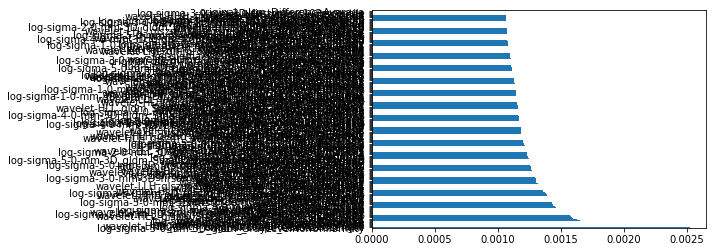

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
Rm_df = pd.read_csv('./Radiomics_Features_Train.csv')
Rm_df.fillna(0, inplace=True)
# Separate features (X) and target variable (y)
df=Rm_df.drop(columns=['Patient_id','nodule no'])
X = df.drop('Malignancy', axis=1)
y = df['Malignancy']

# Split the dataset into training and testing sets


# Standardize the data (important for PCA)
from sklearn.preprocessing import StandardScaler
X_standardized = StandardScaler().fit_transform(X)

model = ExtraTreesClassifier()
model.fit(X_standardized,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

feat_importances.nlargest(200).plot(kind='barh')
plt.show()

In [10]:
top_features_200 = feat_importances.nlargest(200)  # Get the top 200 features
RM_200_top_feature_names = top_features_200.index.tolist()  # Get the names of the top features as a list
print(RM_200_top_feature_names)
X_200=df[RM_200_top_feature_names]



['log-sigma-5-0-mm-3D_gldm_GrayLevelNonUniformity', 'original_shape_LeastAxisLength', 'wavelet-HHH_glrlm_LongRunLowGrayLevelEmphasis', 'original_shape_Maximum2DDiameterSlice', 'log-sigma-4-0-mm-3D_firstorder_Skewness', 'wavelet-HLH_glcm_DifferenceEntropy', 'wavelet-LHL_glrlm_GrayLevelVariance', 'log-sigma-5-0-mm-3D_firstorder_Minimum', 'wavelet-LHL_glcm_SumSquares', 'wavelet-LLL_glcm_Imc2', 'wavelet-LHL_glcm_DifferenceAverage', 'wavelet-HLL_glszm_SmallAreaLowGrayLevelEmphasis', 'wavelet-HHL_glcm_Imc2', 'log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis', 'wavelet-LHL_firstorder_Entropy', 'wavelet-HHL_glszm_SmallAreaHighGrayLevelEmphasis', 'wavelet-LHH_glrlm_RunPercentage', 'log-sigma-5-0-mm-3D_glszm_SmallAreaEmphasis', 'wavelet-LLH_firstorder_Range', 'wavelet-HLL_firstorder_Range', 'log-sigma-4-0-mm-3D_firstorder_Kurtosis', 'original_firstorder_Mean', 'wavelet-LHL_glcm_Idm', 'wavelet-LHH_glcm_Id', 'log-sigma-5-0-mm-3D_firstorder_MeanAbsoluteDeviation', 'wavelet-LLH_glcm_ClusterTen

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import joblib

# Load your dataset
df = pd.read_csv("./Radiomics_Features_Train.csv")

# Define features and target
# Specify the feature names
X_200 = df[RM_200_top_feature_names]
y = df['Malignancy']

# Use RandomOverSampler to oversample the minority class
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_200, y)

# Standardize the data


# Convert the resampled features and target back to DataFrame for ease of handling
X_resampled_df = pd.DataFrame(X_resampled, columns=RM_200_top_feature_names)
y_resampled_df = pd.Series(y_resampled, name='Malignancy')

# Combine the resampled features and target back into a DataFrame
df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Prepare data for cross-validation
X = df_resampled.drop(columns='Malignancy')
y = df_resampled['Malignancy']

# Define the number of folds (K)
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
accuracy_scores = []
best_accuracy = 0
best_model = None

# Specify hyperparameters
rf_hyperparameters = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

# Split the dataset into K folds
for fold, (train_indices, test_indices) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}:")
    
    # Split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
    # Train the model
    model = RandomForestClassifier(random_state=42, **rf_hyperparameters)
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Check if current model is the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

    print("-" * 30)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save the best model

joblib.dump(best_model, 'best_random_forest_model_200_features.pkl')
# Standardize the full dataset for making final predictions
#X_standardized = scaler.transform(X_200)
y_pred_best = best_model.predict(X_200)

# Save predictions to a CSV file
Final_accuracy['Accuracy with 200 Features']=best_accuracy

# Calculate and print the average accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Average Accuracy: {avg_accuracy:.4f}")


Fold 1:
------------------------------
Accuracy: 0.8825
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       153
           1       0.88      0.91      0.89       179

    accuracy                           0.88       332
   macro avg       0.88      0.88      0.88       332
weighted avg       0.88      0.88      0.88       332

Confusion Matrix:
 [[130  23]
 [ 16 163]]
Fold 2:
------------------------------
Accuracy: 0.9335
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       159
           1       0.96      0.91      0.93       172

    accuracy                           0.93       331
   macro avg       0.93      0.93      0.93       331
weighted avg       0.93      0.93      0.93       331

Confusion Matrix:
 [[152   7]
 [ 15 157]]
Fold 3:
------------------------------
Accuracy: 0.9033
Classification Report:
               precisio

Radiomics Model with 100 

In [12]:
top_features_100 = feat_importances.nlargest(100)  # Get the top 100 features
RM_100_top_feature_names = top_features_100.index.tolist()  # Get the names of the top features as a list
print(RM_100_top_feature_names)
X_100=df[RM_100_top_feature_names]

['log-sigma-5-0-mm-3D_gldm_GrayLevelNonUniformity', 'original_shape_LeastAxisLength', 'wavelet-HHH_glrlm_LongRunLowGrayLevelEmphasis', 'original_shape_Maximum2DDiameterSlice', 'log-sigma-4-0-mm-3D_firstorder_Skewness', 'wavelet-HLH_glcm_DifferenceEntropy', 'wavelet-LHL_glrlm_GrayLevelVariance', 'log-sigma-5-0-mm-3D_firstorder_Minimum', 'wavelet-LHL_glcm_SumSquares', 'wavelet-LLL_glcm_Imc2', 'wavelet-LHL_glcm_DifferenceAverage', 'wavelet-HLL_glszm_SmallAreaLowGrayLevelEmphasis', 'wavelet-HHL_glcm_Imc2', 'log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis', 'wavelet-LHL_firstorder_Entropy', 'wavelet-HHL_glszm_SmallAreaHighGrayLevelEmphasis', 'wavelet-LHH_glrlm_RunPercentage', 'log-sigma-5-0-mm-3D_glszm_SmallAreaEmphasis', 'wavelet-LLH_firstorder_Range', 'wavelet-HLL_firstorder_Range', 'log-sigma-4-0-mm-3D_firstorder_Kurtosis', 'original_firstorder_Mean', 'wavelet-LHL_glcm_Idm', 'wavelet-LHH_glcm_Id', 'log-sigma-5-0-mm-3D_firstorder_MeanAbsoluteDeviation', 'wavelet-LLH_glcm_ClusterTen

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import joblib

# Load your dataset
df = pd.read_csv("./Radiomics_Features_Train.csv")

# Define features and target
# Specify the feature names
X_100 = df[RM_100_top_feature_names]
y = df['Malignancy']

# Use RandomOverSampler to oversample the minority class
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_100, y)

# Standardize the data


# Convert the resampled features and target back to DataFrame for ease of handling
X_resampled_df = pd.DataFrame(X_resampled, columns=RM_100_top_feature_names)
y_resampled_df = pd.Series(y_resampled, name='Malignancy')

# Combine the resampled features and target back into a DataFrame
df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Prepare data for cross-validation
X = df_resampled.drop(columns='Malignancy')
y = df_resampled['Malignancy']

# Define the number of folds (K)
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
accuracy_scores = []
best_accuracy = 0
best_model = None

# Specify hyperparameters
rf_hyperparameters = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

# Split the dataset into K folds
for fold, (train_indices, test_indices) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}:")
    
    # Split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
    # Train the model
    model = RandomForestClassifier(random_state=42, **rf_hyperparameters)
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Check if current model is the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

    print("-" * 30)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save the best model

joblib.dump(best_model, 'best_random_forest_model_100_features.pkl')
# Standardize the full dataset for making final predictions
#X_standardized = scaler.transform(X_200)
y_pred_best = best_model.predict(X_100)

# Save predictions to a CSV file
Final_accuracy['Accuracy with 100 Features']=best_accuracy

# Calculate and print the average accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Average Accuracy: {avg_accuracy:.4f}")

Fold 1:
------------------------------
Accuracy: 0.8795
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       153
           1       0.87      0.91      0.89       179

    accuracy                           0.88       332
   macro avg       0.88      0.88      0.88       332
weighted avg       0.88      0.88      0.88       332

Confusion Matrix:
 [[129  24]
 [ 16 163]]
Fold 2:
------------------------------
Accuracy: 0.9305
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       159
           1       0.94      0.93      0.93       172

    accuracy                           0.93       331
   macro avg       0.93      0.93      0.93       331
weighted avg       0.93      0.93      0.93       331

Confusion Matrix:
 [[148  11]
 [ 12 160]]
Fold 3:
------------------------------
Accuracy: 0.8973
Classification Report:
               precisio

In [14]:
Final_accuracy

{'Accuracy with 1218 Features': 0.918429003021148,
 'Accuracy with 200 Features': 0.9335347432024169,
 'Accuracy with 100 Features': 0.9305135951661632}

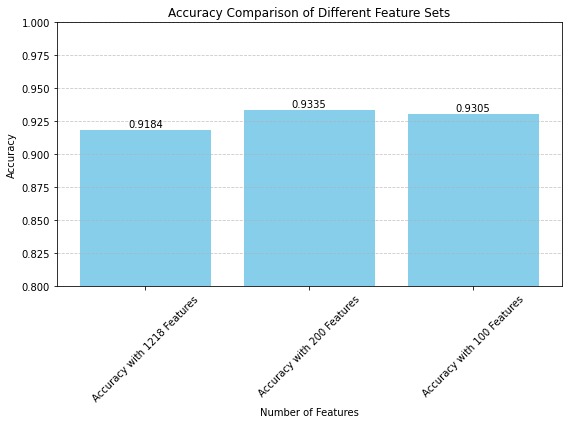

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
data = Final_accuracy

# Extract model names and corresponding accuracies for each scenario
# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(data.keys(), data.values(), color='skyblue')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Feature Sets')
plt.ylim(0.8, 1)  # Set y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adding labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Input
import os
import datetime
import tensorflow as tf
import joblib
import SimpleITK as sitk
import numpy as np
from radiomics import featureextractor,imageoperations
import os
import pandas as pd
from pandas import DataFrame as DF
import warnings
import time
from time import sleep
from tqdm import tqdm
from skimage import measure

In [17]:
Final_accuracy_test={}

In [18]:
import datetime

# Get the current date
current_date = datetime.date.today()

# Format the date as a string in the desired format
current_date = current_date.strftime("%Y-%m-%d")
current_date

'2024-06-09'

In [19]:
Data_Path= r'../../DataSet Files/Test_Files'
error_file="Error_list_radiomics.txt"
Test_patients = [os.path.join(Data_Path,name) for name in os.listdir(Data_Path) if os.path.isdir(os.path.join(Data_Path, name))]
Test_patients = sorted(Test_patients)
Test_patients

['../../DataSet Files/Test_Files\\LIDC-IDRI-0007',
 '../../DataSet Files/Test_Files\\LIDC-IDRI-0151',
 '../../DataSet Files/Test_Files\\LIDC-IDRI-0269',
 '../../DataSet Files/Test_Files\\LIDC-IDRI-0423',
 '../../DataSet Files/Test_Files\\LIDC-IDRI-0640',
 '../../DataSet Files/Test_Files\\LIDC-IDRI-0712',
 '../../DataSet Files/Test_Files\\LIDC-IDRI-0726',
 '../../DataSet Files/Test_Files\\LIDC-IDRI-0863',
 '../../DataSet Files/Test_Files\\LIDC-IDRI-0932',
 '../../DataSet Files/Test_Files\\LIDC-IDRI-0966']

In [20]:
def Extract_Features(image,mask,params_path):
    paramsFile = os.path.abspath(params_path)
    extractor = featureextractor.RadiomicsFeatureExtractor(paramsFile)
    result = extractor.execute(image, mask)
    general_info = {'diagnostics_Configuration_EnabledImageTypes','diagnostics_Configuration_Settings',
                    'diagnostics_Image-interpolated_Maximum','diagnostics_Image-interpolated_Mean',
                    'diagnostics_Image-interpolated_Minimum','diagnostics_Image-interpolated_Size',
                    'diagnostics_Image-interpolated_Spacing','diagnostics_Image-original_Hash',
                    'diagnostics_Image-original_Maximum','diagnostics_Image-original_Mean',
                    'diagnostics_Image-original_Minimum','diagnostics_Image-original_Size',
                    'diagnostics_Image-original_Spacing','diagnostics_Mask-interpolated_BoundingBox',
                    'diagnostics_Mask-interpolated_CenterOfMass','diagnostics_Mask-interpolated_CenterOfMassIndex',
                    'diagnostics_Mask-interpolated_Maximum','diagnostics_Mask-interpolated_Mean',
                    'diagnostics_Mask-interpolated_Minimum','diagnostics_Mask-interpolated_Size',
                    'diagnostics_Mask-interpolated_Spacing','diagnostics_Mask-interpolated_VolumeNum',
                    'diagnostics_Mask-interpolated_VoxelNum','diagnostics_Mask-original_BoundingBox',
                    'diagnostics_Mask-original_CenterOfMass','diagnostics_Mask-original_CenterOfMassIndex',
                    'diagnostics_Mask-original_Hash','diagnostics_Mask-original_Size',
                    'diagnostics_Mask-original_Spacing','diagnostics_Mask-original_VolumeNum',
                    'diagnostics_Mask-original_VoxelNum','diagnostics_Versions_Numpy',
                    'diagnostics_Versions_PyRadiomics','diagnostics_Versions_PyWavelet',
                    'diagnostics_Versions_Python','diagnostics_Versions_SimpleITK',
                    'diagnostics_Image-original_Dimensionality'}
    features = dict((key, value) for key, value in result.items() if key not in general_info)
    feature_info = dict((key, value) for key, value in result.items() if key in general_info)
    return features,feature_info

In [21]:
Feature = []
test_patients = [os.path.join(Data_Path,name) for name in os.listdir(Data_Path) if os.path.isdir(os.path.join(Data_Path, name))]
test_patients = sorted(test_patients)    
for patients in tqdm(test_patients):
        #sleep(0.01)
        print(patients[-14:])
        dcm_File = patients[-14:]
        count=(len([entry for entry in os.listdir(patients) if os.path.isfile(os.path.join(patients, entry))]))
        try:

            for i in range(1,int(count/2)+1):
                roi_path = Data_Path+'/'+dcm_File+"/"+dcm_File+'_'+str(i)+'_roi.npy'
                img=np.load(roi_path)
                ROI = sitk.GetImageFromArray(img)
            
                mask_path = Data_Path+'/'+dcm_File+"/"+dcm_File+'_'+str(i)+'_label.npy'
                msk=np.load(mask_path)
                Mask = sitk.GetImageFromArray(msk)
            
                features, feature_info = Extract_Features(ROI, Mask, 'params.yaml')
                features['Patient_id']=dcm_File+'_'+str(i)+'_roi.npy'
                Feature.append(features)
        except Exception as Error:
            with open('Error_list_radiomics.txt', 'a') as error_file:
                error_file.write(f"Error: {dcm_File}:{str(Error)}\n")
                print("Error: "+dcm_File+":"+str(Error)+"\n")
            continue
    
df = DF(Feature).fillna('0')
df.to_csv(f"RM_features_{current_date}.csv", index=False,sep=',')


  0%|          | 0/10 [00:00<?, ?it/s]

LIDC-IDRI-0007


 10%|█         | 1/10 [00:01<00:11,  1.24s/it]

LIDC-IDRI-0151


 20%|██        | 2/10 [00:01<00:07,  1.10it/s]

LIDC-IDRI-0269


 30%|███       | 3/10 [00:02<00:05,  1.24it/s]

LIDC-IDRI-0423


 40%|████      | 4/10 [00:03<00:05,  1.13it/s]

LIDC-IDRI-0640


 50%|█████     | 5/10 [00:05<00:05,  1.11s/it]

LIDC-IDRI-0712


 60%|██████    | 6/10 [00:06<00:05,  1.34s/it]

LIDC-IDRI-0726


 70%|███████   | 7/10 [00:07<00:03,  1.11s/it]

LIDC-IDRI-0863


 80%|████████  | 8/10 [00:09<00:02,  1.45s/it]

LIDC-IDRI-0932


 90%|█████████ | 9/10 [00:11<00:01,  1.40s/it]

LIDC-IDRI-0966


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [22]:
Test_Data="./Radiomics_Features_Test.csv"
Test_Data

'./Radiomics_Features_Test.csv'

In [23]:
test_df=pd.read_csv(Test_Data)

#from sklearn.preprocessing import StandardScaler
#X_standardized = StandardScaler().fit_transform(Rm_200)
test_df

Patient_id  nodule no  Malignancy  \
0    LIDC-IDRI-0188_5_roi.npy          5           0   
1    LIDC-IDRI-0815_1_roi.npy          1           0   
2    LIDC-IDRI-0722_3_roi.npy          3           0   
3    LIDC-IDRI-0360_1_roi.npy          1           0   
4    LIDC-IDRI-0442_2_roi.npy          2           0   
..                        ...        ...         ...   
274  LIDC-IDRI-0311_2_roi.npy          2           1   
275  LIDC-IDRI-0024_1_roi.npy          1           0   
276  LIDC-IDRI-0070_3_roi.npy          3           0   
277  LIDC-IDRI-0202_1_roi.npy          1           0   
278  LIDC-IDRI-0787_2_roi.npy          2           0   

     original_shape_Elongation  original_shape_Flatness  \
0                     0.317123                 0.241002   
1                     0.438790                 0.320599   
2                     0.159157                 0.097434   
3                     0.802400                 0.609155   
4                     0.872474                 0.768964   
..                         ...                      ...   
274                   0.730560                 0.517611   
275                   0.981830                 0.830844   
276                   0.840895                 0.637700   
277                   0.702045                 0.647059   
278                   0.894861                 0.683136   

     original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                         13.456962                       55.837593   
1                          7.877371                       24.570779   
2                          5.528393                       56.739915   
3                          3.902886                        6.407046   
4                          4.248386                        5.524815   
..                              ...                             ...   
274                        7.454697                       14.402116   
275                        5.191199                        6.248102   
276                        4.985539                        7.818003   
277                        5.251374                        8.115762   
278                        3.168146                        4.637653   

     original_shape_Maximum2DDiameterColumn  \
0                                 20.248457   
1                                 22.803509   
2                                 13.453624   
3                                  6.324555   
4                                  6.324555   
..                                      ...   
274                               15.264338   
275                                7.615773   
276                                8.944272   
277                                9.219544   
278                                5.099020   

     original_shape_Maximum2DDiameterRow  \
0                              17.888544   
1                              14.317821   
2                              11.401754   
3                               7.280110   
4                               6.324555   
..                                   ...   
274                            14.317821   
275                             7.280110   
276                             7.615773   
277                             9.219544   
278                             5.099020   

     original_shape_Maximum2DDiameterSlice  original_shape_Maximum3DDiameter  \
0                                23.600847                         60.671245   
1                                21.189620                         23.958297   
2                                12.369317                         40.472213   
3                                 8.062258                          8.124038   
4                                 5.830952                          6.403124   
..                                     ...                               ...   
274                              14.142136                         15.842980   
275                               7.810250        

Radiomics Model with 1218 Features

In [24]:
import pandas as pd
import joblib

# Load the saved model
model = joblib.load('./best_random_forest_model_1218_features.pkl')

# Load the test dataset


# Assuming you've already preprocessed your test data similarly to the training data
X_test = test_df.drop(columns=['Patient_id','nodule no','Malignancy'])

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
# Make predictions on the test set
y_pred_best = model.predict(X_test)

# Evaluate the performance of the model using appropriate metrics

print(y_pred_best)

[0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


c:\Users\VIRUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [25]:

y_test_p=pd.DataFrame(y_pred_best)
y_test_p['Image File']=test_df['Patient_id']
Pr_file=f"test_{current_date}_1218.csv"
y_test_p.to_csv(Pr_file)

In [26]:
import pandas as pd

# Read the CSV files
try:
    radiomics_df = pd.read_csv('./Radiomics_Feature.csv')
    example_df = pd.read_csv(Pr_file)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Print the first few rows of the dataframes to check the structure


# Merge the dataframes based on the patient_id and Image File columns
try:
    merged_df = pd.merge(example_df, radiomics_df, left_on='Image File', right_on='Patient_id', how='left')
    #print(merged_df.head())
except KeyError as e:
    print(f"Error: {e}")
    exit()

# Select relevant columns, assuming you want to keep all columns from example_df and add Malignancy
y_test = merged_df[['Malignancy']]




In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_best)
report = classification_report(y_test, y_pred_best)
conf_matrix = confusion_matrix(y_test, y_pred_best)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
Final_accuracy_test['1218 Features']=accuracy

Accuracy: 0.7634408602150538
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       219
           1       0.35      0.12      0.17        60

    accuracy                           0.76       279
   macro avg       0.57      0.53      0.52       279
weighted avg       0.70      0.76      0.71       279

Confusion Matrix:
 [[206  13]
 [ 53   7]]


200 Features

In [28]:
import pandas as pd
import joblib

# Load the saved model
model = joblib.load('./best_random_forest_model_200_features.pkl')

# Load the test dataset


# Assuming you've already preprocessed your test data similarly to the training data
X_test = test_df[RM_200_top_feature_names]

# Make predictions on the test set
y_pred_best = model.predict(X_test)

# Evaluate the performance of the model using appropriate metrics

print(y_pred_best)
y_test_p=pd.DataFrame(y_pred_best)
y_test_p['Image File']=test_df['Patient_id']
Pr_file=f"test_{current_date}_200.csv"
y_test_p.to_csv(Pr_file)

[1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [29]:
import pandas as pd

# Read the CSV files
try:
    radiomics_df = pd.read_csv('./Radiomics_Feature.csv')
    example_df = pd.read_csv(Pr_file)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Print the first few rows of the dataframes to check the structure


# Merge the dataframes based on the patient_id and Image File columns
try:
    merged_df = pd.merge(example_df, radiomics_df, left_on='Image File', right_on='Patient_id', how='left')
    #print(merged_df.head())
except KeyError as e:
    print(f"Error: {e}")
    exit()

# Select relevant columns, assuming you want to keep all columns from example_df and add Malignancy
y_test = merged_df[['Malignancy']]

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_best)
report = classification_report(y_test, y_pred_best)
conf_matrix = confusion_matrix(y_test, y_pred_best)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
Final_accuracy_test['200 Features']=accuracy

Accuracy: 0.7885304659498208
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.87       219
           1       0.52      0.28      0.37        60

    accuracy                           0.79       279
   macro avg       0.67      0.61      0.62       279
weighted avg       0.76      0.79      0.76       279

Confusion Matrix:
 [[203  16]
 [ 43  17]]


100 Features

In [31]:
import pandas as pd
import joblib

# Load the saved model
model = joblib.load('./best_random_forest_model_100_features.pkl')

# Load the test dataset


# Assuming you've already preprocessed your test data similarly to the training data
X_test = test_df[RM_100_top_feature_names]

# Make predictions on the test set
y_pred_best = model.predict(X_test)

# Evaluate the performance of the model using appropriate metrics

print(y_pred_best)
y_test_p=pd.DataFrame(y_pred_best)
y_test_p['Image File']=test_df['Patient_id']
Pr_file=f"test_{current_date}_200.csv"
y_test_p.to_csv(Pr_file)

[1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [32]:
import pandas as pd

# Read the CSV files
try:
    radiomics_df = pd.read_csv('./Radiomics_Feature.csv')
    example_df = pd.read_csv(Pr_file)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Print the first few rows of the dataframes to check the structure


# Merge the dataframes based on the patient_id and Image File columns
try:
    merged_df = pd.merge(example_df, radiomics_df, left_on='Image File', right_on='Patient_id', how='left')
    #print(merged_df.head())
except KeyError as e:
    print(f"Error: {e}")
    exit()

# Select relevant columns, assuming you want to keep all columns from example_df and add Malignancy
y_test = merged_df[['Malignancy']]

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_best)
report = classification_report(y_test, y_pred_best)
conf_matrix = confusion_matrix(y_test, y_pred_best)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
Final_accuracy_test['100 Features']=accuracy

Accuracy: 0.7670250896057348
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86       219
           1       0.42      0.23      0.30        60

    accuracy                           0.77       279
   macro avg       0.62      0.57      0.58       279
weighted avg       0.73      0.77      0.74       279

Confusion Matrix:
 [[200  19]
 [ 46  14]]


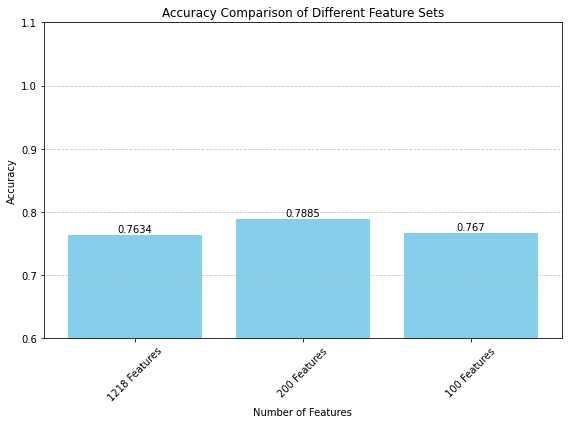

In [34]:
data = Final_accuracy_test

# Extract model names and corresponding accuracies for each scenario
# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(data.keys(), data.values(), color='skyblue')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Feature Sets')
plt.ylim(0.6, 1.1)  # Set y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adding labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [35]:
test_df=pd.read_csv('./Radiomics_Feature.csv')
Final_accuracy_test_1={}

In [36]:
import pandas as pd
import joblib

# Load the saved model
model = joblib.load('./best_random_forest_model_200_features.pkl')

# Load the test dataset


# Assuming you've already preprocessed your test data similarly to the training data


X_test = test_df[RM_200_top_feature_names]
# Make predictions on the test set
y_pred_best_2 = model.predict(X_test)

# Evaluate the performance of the model using appropriate metrics

print(y_pred_best_2)

y_test_p=pd.DataFrame(y_pred_best_2)
y_test_p['Image File']=test_df['Patient_id']
Pr_file=f"test_{current_date}_200_a1.csv"
y_test_p.to_csv(Pr_file)
import pandas as pd

# Read the CSV files
try:
    radiomics_df = pd.read_csv('./Radiomics_Feature.csv')
    example_df = pd.read_csv(Pr_file)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Print the first few rows of the dataframes to check the structure


# Merge the dataframes based on the patient_id and Image File columns
try:
    merged_df = pd.merge(example_df, radiomics_df, left_on='Image File', right_on='Patient_id', how='left')
    #print(merged_df.head())
except KeyError as e:
    print(f"Error: {e}")
    exit()

# Select relevant columns, assuming you want to keep all columns from example_df and add Malignancy
y_test = merged_df[['Malignancy']]
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_best_2)
report = classification_report(y_test, y_pred_best_2)
conf_matrix = confusion_matrix(y_test, y_pred_best_2)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
Final_accuracy_test_1['200 Features']=accuracy


[1 1 0 ... 0 0 0]
Accuracy: 0.9447236180904522
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      1047
           1       0.93      0.84      0.88       346

    accuracy                           0.94      1393
   macro avg       0.94      0.91      0.92      1393
weighted avg       0.94      0.94      0.94      1393

Confusion Matrix:
 [[1024   23]
 [  54  292]]


In [37]:
import pandas as pd
import joblib

# Load the saved model
model = joblib.load('./best_random_forest_model_100_features.pkl')

# Load the test dataset


# Assuming you've already preprocessed your test data similarly to the training data


X_test = test_df[RM_100_top_feature_names]
# Make predictions on the test set
y_pred_best_3 = model.predict(X_test)

# Evaluate the performance of the model using appropriate metrics

print(y_pred_best_3)

y_test_p=pd.DataFrame(y_pred_best_3)
y_test_p['Image File']=test_df['Patient_id']
Pr_file=f"test_{current_date}_200_a1.csv"
y_test_p.to_csv(Pr_file)
import pandas as pd

# Read the CSV files
try:
    radiomics_df = pd.read_csv('./Radiomics_Feature.csv')
    example_df = pd.read_csv(Pr_file)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Print the first few rows of the dataframes to check the structure


# Merge the dataframes based on the patient_id and Image File columns
try:
    merged_df = pd.merge(example_df, radiomics_df, left_on='Image File', right_on='Patient_id', how='left')
    #print(merged_df.head())
except KeyError as e:
    print(f"Error: {e}")
    exit()

# Select relevant columns, assuming you want to keep all columns from example_df and add Malignancy
y_test = merged_df[['Malignancy']]
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_best_3)
report = classification_report(y_test, y_pred_best_3)
conf_matrix = confusion_matrix(y_test, y_pred_best_3)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
Final_accuracy_test_1['100 Features']=accuracy

[1 1 0 ... 0 0 0]
Accuracy: 0.9389806173725772
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1047
           1       0.91      0.84      0.87       346

    accuracy                           0.94      1393
   macro avg       0.93      0.91      0.92      1393
weighted avg       0.94      0.94      0.94      1393

Confusion Matrix:
 [[1017   30]
 [  55  291]]


In [38]:
import pandas as pd
import joblib

# Load the saved model
model = joblib.load('./best_random_forest_model_1218_features.pkl')

# Load the test dataset


# Assuming you've already preprocessed your test data similarly to the training data
X_test = test_df.drop(columns=['Patient_id','nodule no','Malignancy'])

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
# Make predictions on the test set
y_pred_best_1 = model.predict(X_test)

# Evaluate the performance of the model using appropriate metrics

print(y_pred_best_1)

y_test_p=pd.DataFrame(y_pred_best_1)
y_test_p['Image File']=test_df['Patient_id']
Pr_file=f"test_{current_date}_200_a.csv"
y_test_p.to_csv(Pr_file)
import pandas as pd

# Read the CSV files
try:
    radiomics_df = pd.read_csv('./Radiomics_Feature.csv')
    example_df = pd.read_csv(Pr_file)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Print the first few rows of the dataframes to check the structure


# Merge the dataframes based on the patient_id and Image File columns
try:
    merged_df = pd.merge(example_df, radiomics_df, left_on='Image File', right_on='Patient_id', how='left')
    #print(merged_df.head())
except KeyError as e:
    print(f"Error: {e}")
    exit()

# Select relevant columns, assuming you want to keep all columns from example_df and add Malignancy
y_test = merged_df[['Malignancy']]
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_best_1)
report = classification_report(y_test, y_pred_best_1)
conf_matrix = confusion_matrix(y_test, y_pred_best_1)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
Final_accuracy_test_1['1218 Features']=accuracy

[1 1 0 ... 0 0 0]


c:\Users\VIRUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9310839913854989
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      1047
           1       0.92      0.79      0.85       346

    accuracy                           0.93      1393
   macro avg       0.93      0.88      0.90      1393
weighted avg       0.93      0.93      0.93      1393

Confusion Matrix:
 [[1023   24]
 [  72  274]]


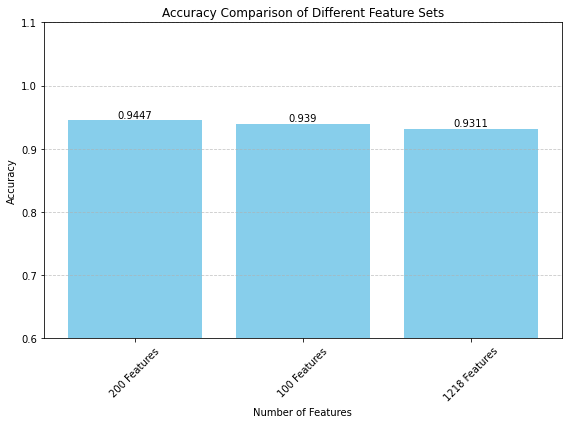

In [39]:
data = Final_accuracy_test_1

# Extract model names and corresponding accuracies for each scenario
# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(data.keys(), data.values(), color='skyblue')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Feature Sets')
plt.ylim(0.6, 1.1)  # Set y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adding labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()